In [17]:
%pip install synthcity[all]
%pip install catenets
%pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 63.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 7.0 MB/s eta 0:00:00
     ━━━

In [1]:
from synthcity.plugins import Plugins
from synthcity.metrics.eval_statistical import AlphaPrecision, InverseKLDivergence, MaximumMeanDiscrepancy, WassersteinDistance
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.utils.serialization import save_to_file, load_from_file
import matplotlib.pyplot as plt
import pandas as pd
from catenets.models.torch import *
from catenets.experiment_utils.simulation_utils import simulate_treatment_setup
import numpy as np
from sklearn.metrics import mean_squared_error
from os import listdir
from sklearn.preprocessing import OneHotEncoder
from captum.attr import *
import torch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import multivariate_normal
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from synthcity.plugins.core.constraints import Constraints
import random


[KeOps] Warning : There were warnings or errors :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:16:10: fatal error: cuda.h: No such file or directory
 #include <cuda.h>
          ^~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warn

In [2]:
def train_models(gen_list, datasets, n_runs):
    for g in gen_list:
        for dataset in datasets:
            for i in range(n_runs):
                print(f'Training model {g} iteration {i} on dataset {dataset}')
                model = Plugins().get(g)
                model.fit(datasets[dataset])
                fp = 'models/' + g + '_' + dataset + '_' + str(i) + '.pkl'
                print(f'Saving model {g} iteration {i} on dataset {dataset}')
                save_to_file(fp, model)

In [3]:
def generate_data(models, n):
    for fp in models:
        g = load_from_file('models/' + fp)
        df = g.generate(count = n).dataframe()

        name_list = fp.split('.')
        name = name_list[0]
        df.to_csv('syn_data/' + name + '.csv', index=False)

In [4]:
def get_CATE_PEHE(datasets, X_t, mu0, mu1, outcome_col, treatment_col, include_S = True):
    results = pd.DataFrame(columns=['generator', 'learner', 'rmse'])
    for d in datasets:
        dataset = datasets[d]
        X = np.array(dataset.drop([treatment_col, outcome_col], axis=1))
        y = np.array(dataset[outcome_col])
        w = np.array(dataset[treatment_col])  
        if include_S:
            learners = [TNet(), SNet(), PWNet(), RANet(), DRNet()]
        else:
            learners = [TNet(), PWNet(), RANet(), DRNet()]

        for learner in learners:
            learner.fit(X,y,w)
            pred = learner.predict(X_t)
            cate = mu1 - mu0
            rmse = mean_squared_error(cate, pred, squared = False)
            results.loc[len(results.index)] = [d, learner.__str__(), rmse]
            print(f'{learner} complete on {d}')

    return results

In [5]:
def get_CATE_estimates(training_datasets, X_t, mu0, mu1, outcome_col, treatment_col, include_S = True):
    results = X_t.copy()
    results = pd.concat([results, mu0, mu1], axis=1)
    results['CATE'] = results['mu1'] - results['mu0']

    for d in training_datasets:
        dataset = training_datasets[d]
        X = np.array(dataset.drop([treatment_col, outcome_col], axis=1))
        y = np.array(dataset[outcome_col])
        w = np.array(dataset[treatment_col])

        if include_S:
            learners = [TNet(), SNet(), PWNet(), RANet(), DRNet()]
        else:
            learners = [TNet(), PWNet(), RANet(), DRNet()]

        for learner in learners:
            learner.fit(X,y,w)
            X_t_array = np.array(X_t)
            pred = learner.predict(X_t_array)
            col = d.split('.')[0] + '_' + learner.__str__()
            results[col] = pred
        
            print(f'{learner} complete on {d}')
            
    return results

In [6]:
def rate_of_flipping(d, cols):
    rates = pd.DataFrame()
    for c in cols:
        m = d['CATE'] * d[c]
        wrong = sum(m<0)
        rate = wrong / d.shape[0]
        rates[c] = [rate]
    rates = rates.transpose()
    return rates

In [7]:
def standard_metrics(datasets, real, metrics):
    results = pd.DataFrame(columns = ['dataset', 'metric', 'result'])
    for d in datasets:
        dataset = GenericDataLoader(datasets[d])
        for m in metrics:
            metric = metrics[m]
            result = metric.evaluate(real, dataset)
            for r in result:
                results.loc[len(results.index)] = [d, r, result[r]]
    
    return results

In [8]:
def encode_acic_datasets(real, syn_data):
    encoder = OneHotEncoder()
    categorical = ['x_2', 'x_21', 'x_24']
    encoded = encoder.fit_transform(real[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    real_encoded = pd.concat([real, encoded_df], axis=1)
    real_encoded.drop(categorical, axis=1, inplace=True)

    syn_data_encoded = {}
    for d in syn_data:
        syn_dataset = syn_data[d]
        encoded = encoder.transform(syn_dataset[categorical])
        encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
        syn_encoded = pd.concat([syn_dataset, encoded_df], axis=1)
        syn_encoded.drop(categorical, axis=1, inplace=True)
        syn_data_encoded[d] = syn_encoded
    
    return real_encoded, syn_data_encoded

In [184]:
def encode_acic(real, syn_dataset):
    encoder = OneHotEncoder()
    categorical = ['x_2', 'x_21', 'x_24']
    encoded = encoder.fit_transform(real[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    real_encoded = pd.concat([real, encoded_df], axis=1)
    real_encoded.drop(categorical, axis=1, inplace=True)
    encoded = encoder.transform(syn_dataset[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    syn_encoded = pd.concat([syn_dataset, encoded_df], axis=1)
    syn_encoded.drop(categorical, axis=1, inplace=True)
    return real_encoded, syn_encoded

## New metrics

In [9]:
def covariate_fidelity(real, syn_data, treatment_col, outcome_col, save=False, fp=''):
    alpha = AlphaPrecision()
    results = pd.DataFrame(columns = ['dataset', 'f0', 'f1', 'covariate fidelity'])

    for d in syn_data:
        real_0 = real[real[treatment_col] == 0].drop([treatment_col, outcome_col], axis=1)
        real_1 = real[real[treatment_col] == 1].drop([treatment_col, outcome_col], axis=1)

        n_0 = len(real_0)
        n_1 = len(real_1)
        synth = syn_data[d]
        synth_0 = synth[synth[treatment_col] == 0].drop([treatment_col, outcome_col], axis=1)
        synth_1 = synth[synth[treatment_col] == 1].drop([treatment_col, outcome_col], axis=1)

        s_0 = len(synth_0)
        s_1 = len(synth_1)

        if n_0 <= s_0:
            synth_0 = synth_0[0:n_0]
        else:
            real_0 = real_0[0:s_0]

        if n_1 <= s_1:
            synth_1 = synth_1[0:n_1]
        else:
            real_1 = real_1[0:s_1]

        f0 = alpha.evaluate(GenericDataLoader(real_0), GenericDataLoader(synth_0))['delta_precision_alpha_OC']
        f1 = alpha.evaluate(GenericDataLoader(real_1), GenericDataLoader(synth_1))['delta_precision_alpha_OC']
        pi = n_0 / (n_0 + n_1)

        f = pi * f1 + (1-pi)*f0
        results.loc[len(results)] = [d, f0, f1, f]
    
    if save:
        results.to_csv(fp, index=False)
    return results


In [10]:
def evaluate_f(real, synth, treatment_col, outcome_col):
    alpha = AlphaPrecision(random_state = random.randint(0, 1000000))

    real_0 = real[real[treatment_col] == 0].drop([treatment_col, outcome_col], axis=1)
    real_1 = real[real[treatment_col] == 1].drop([treatment_col, outcome_col], axis=1)
    n_0 = len(real_0)
    n_1 = len(real_1)
    synth_0 = synth[synth[treatment_col] == 0].drop([treatment_col, outcome_col], axis=1)
    synth_1 = synth[synth[treatment_col] == 1].drop([treatment_col, outcome_col], axis=1)
    s_0 = len(synth_0)
    s_1 = len(synth_1)

    if n_0 <= s_0:
        synth_0 = synth_0[0:n_0]
    else:
        real_0 = real_0[0:s_0]

    if n_1 <= s_1:
        synth_1 = synth_1[0:n_1]
    else:
        real_1 = real_1[0:s_1]

    f0 = alpha.evaluate(GenericDataLoader(real_0), GenericDataLoader(synth_0))['delta_precision_alpha_OC']
    f1 = alpha.evaluate(GenericDataLoader(real_1), GenericDataLoader(synth_1))['delta_precision_alpha_OC']
    pi = n_0 / (n_0 + n_1)

    return pi * f1 + (1-pi)*f0

In [11]:
def propensity_distance(p_real, p_synth):
    return 1 - abs(p_synth - p_real) / max(p_real, 1-p_real)

In [12]:
def propensity_matching(real, syn_data, treatment_col, outcome_col, cov_columns, save=False, fp=''):
    #need to deal with continuous
    results = pd.DataFrame(columns = ['dataset', 'D'])
    real = real.drop(outcome_col, axis=1)
    real_covariates = real.drop_duplicates(cov_columns).reset_index(drop=True)[cov_columns]

    for d in syn_data:

        synth = syn_data[d]
        total_p_dist = 0

        for index, condition in real_covariates.iterrows():

            matches = [real[i] == condition[i] for i in cov_columns]
            match = matches[0]
            
            for series in matches[1:]:
                match &= series

            p_real = sum(real[match][treatment_col]) / len(real[match])
            matches = [synth[i] == condition[i] for i in cov_columns]
            match = matches[0]

            for series in matches[1:]:
                match &= series

            if len(synth[match]) == 0:
                p_synth = 0
            else:
                p_synth = sum(synth[match][treatment_col]) / len(synth[match])
            total_p_dist += propensity_distance(p_real, p_synth)

        avg_p_dist = total_p_dist / len(real_covariates)
        results.loc[len(results)] = [d, avg_p_dist]

    if save:
        results.to_csv(fp, index=False)
    return results

In [13]:
def train_propensity_function(real, treatment_col, outcome_col):
    X = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real[treatment_col])
    classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    classifier.fit(X, y)

    return classifier

In [14]:
def get_d_max(props):
    propensities_max = [0 if i >= 0.5 else 1 for i in props]

    return mean_squared_error(props, propensities_max, squared=False)

In [15]:
def evaluate_d(real, synth, treatment_col, outcome_col):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    pi_real = train_propensity_function(real, treatment_col, outcome_col)
    pi_synth = train_propensity_function(synth, treatment_col, outcome_col)

    #should we be testing across some real test set, not the whole real?? yes
    probabilities_real = pi_real.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
    propensities_real = probabilities_real[:, 1]

    probabilities_synth = pi_synth.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
    propensities_synth = probabilities_synth[:, 1]

    d_max = get_d_max(propensities_real)

    return 1 - mean_squared_error(propensities_real, propensities_synth, squared=False)/d_max

In [16]:
def cosine_average_first(v1, v2):
    return cosine_similarity(v1.sum(axis=0).reshape(1,-1), v2.sum(axis=0).reshape(1,-1))[0][0]

In [17]:
def cosine_average_second(v1, v2):
    sims = [cosine_similarity(v1[[i]], v2[[i]])[0][0] for i in range(len(v1))]
    return sum(sims) / len(v1)

In [18]:
def evaluate_u_int(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]


    l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    ig_real = IntegratedGradients(l_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    attr_real = ig_real.attribute(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    ig_synth = IntegratedGradients(l_synth)
    attr_synth = ig_synth.attribute(X_t)

    first, second = cosine_average_first(attr_real, attr_synth), cosine_average_second(attr_real, attr_synth)
    return first, second

In [19]:
def utility_int(real, synths, test, treatment_col, outcome_col, n_units, n_iter, save=False, save_name=''):
    results = pd.DataFrame(columns = ['dataset', 'first', 'second'])

    for _ in range(n_iter):
        l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)
        ig_real = IntegratedGradients(l_real)
        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        attr_real = ig_real.attribute(X_t)

        for s in synths:
            synth = synths[s]
            l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
            X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
            y_synth = np.array(synth[outcome_col])
            w_synth = np.array(synth[treatment_col])
            l_synth.fit(X_synth, y_synth, w_synth)
            ig_synth = IntegratedGradients(l_synth)
            attr_synth = ig_synth.attribute(X_t)

            first, second = cosine_average_first(attr_real, attr_synth), cosine_average_second(attr_real, attr_synth)
            results.loc[len(results)] = [s, first, second]

    if save:
        results.to_csv(f'utility_features_{save_name}.csv')
    
    return results

In [20]:
def evaluate_u_pehe(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    pred_real = l_real.predict(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    pred_synth = l_synth.predict(X_t)

    pehe = mean_squared_error(pred_real.cpu().detach().numpy(), pred_synth.cpu().detach().numpy(), squared=False)
    return pehe

In [21]:
def utility_pehe(real, synths, test, treatment_col, outcome_col, n_units, n_iter, save=False, save_name=''):
    results = pd.DataFrame(columns = ['dataset', 'pehe'])

    for _ in range(n_iter):
        l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)

        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        pred_real = l_real.predict(X_t)

        for s in synths:
            synth = synths[s]
            l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
            X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
            y_synth = np.array(synth[outcome_col])
            w_synth = np.array(synth[treatment_col])
            l_synth.fit(X_synth, y_synth, w_synth)
            
            pred_synth = l_synth.predict(X_t)

            pehe = mean_squared_error(pred_real.cpu().detach().numpy(), pred_synth.cpu().detach().numpy(), squared=False)
            results.loc[len(results)] = [s, pehe]

    if save:
        results.to_csv(f'utility_pehe_{save_name}.csv')
    
    return results

In [22]:
def evaluate_u_policy(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    pred_real = l_real.predict(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    pred_synth = l_synth.predict(X_t)

    pred_mult = pd.DataFrame(pred_real * pred_synth)
    num_pos = len(pred_mult[pred_mult[0]>0])
    correct_rate = num_pos / len(pred_real)

    return correct_rate

In [23]:
def utility_policy(real, synths, test, treatment_col, outcome_col, n_units, n_iter, save=False, save_name=''):
    results = pd.DataFrame(columns = ['dataset', 'policy'])

    for _ in range(n_iter):
        l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)

        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        pred_real = l_real.predict(X_t)

        for s in synths:
            synth = synths[s]
            l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
            X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
            y_synth = np.array(synth[outcome_col])
            w_synth = np.array(synth[treatment_col])
            l_synth.fit(X_synth, y_synth, w_synth)
            
            pred_synth = l_synth.predict(X_t)

            pred_mult = pd.DataFrame(pred_real * pred_synth)
            num_pos = len(pred_mult[pred_mult[0]>0])
            correct_rate = num_pos / len(pred_real)
            
            results.loc[len(results)] = [s, correct_rate]

    if save:
        results.to_csv(f'utility_policy_{save_name}.csv')
        
    return results

## Load real datasets

In [24]:
ihdp_full = pd.read_csv('../Datasets/ihdp.csv')
ihdp = ihdp_full.drop(['y_cfactual', 'mu0', 'mu1'], axis=1)
ihdp['treatment'] = ihdp['treatment'].astype(int)
#train on 80% of the data, the remaining 20% for testing of CATE estimators
train_ihdp = ihdp.loc[[i for i in range(600)]]
test_ihdp = ihdp.loc[[i+600 for i in range(147)]]

In [25]:
jobs =pd.read_csv('../Datasets/jobs_small.csv')

In [26]:
twins = pd.read_csv('../Datasets/twins.csv')

In [27]:
acic_full = pd.read_csv('../Datasets/acic.csv')
acic_full['y'] = acic_full['y0']
acic_full.loc[acic_full['z']==1, 'y'] = acic_full.loc[acic_full['z']==1, 'y1']

acic = acic_full.drop(['y0', 'y1', 'mu0', 'mu1'], axis=1)
acic_train = acic.loc[[i for i in range(4000)]]
acic_test = acic.loc[[i+4000 for i in range(802)]]

## Utility testing

In [377]:
syn_data = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

syn_data['real'] = train_ihdp

In [383]:
results_pehe = utility_pehe(train_ihdp, syn_data, test_ihdp, 'treatment', 'y_factual', 25, 3, save=True, save_name='ihdp')

In [392]:
results_policy = utility_policy(train_ihdp, syn_data, test_ihdp, 'treatment', 'y_factual', 25, 3, save=True, save_name='ihdp')

In [451]:
results_features = pd.read_csv('feature_importance_ihdp_IG.csv')

In [393]:
results_policy['gen'] = [i.split('_')[0] for i in results_policy['dataset']]
results_pehe['gen'] = [i.split('_')[0] for i in results_pehe['dataset']]

In [468]:
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

acic_train_encoded = acic_encoded.loc[[i for i in range(4000)]]
acic_test_encoded = acic_encoded.loc[[i+4000 for i in range(802)]]

In [469]:
results_pehe = utility_pehe(acic_train_encoded, syn_data_encoded, acic_test_encoded, 'z', 'y', 82, 1, save=True, save_name='acic')

In [473]:
results_policy = utility_policy(acic_train_encoded, syn_data_encoded, acic_test_encoded, 'z', 'y', 82, 1, save=True, save_name='acic')

In [476]:
results_features = utility_int(acic_train_encoded, syn_data_encoded, acic_test_encoded, 'z', 'y', 82, 1, save=True, save_name='acic')

## New metric testing

In [479]:
syn_data_ihdp = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data_ihdp[i] = pd.read_csv('syn_data/'+i)
        
syn_data_ihdp['real'] = ihdp

In [480]:
syn_data_acic = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data_acic[i] = pd.read_csv('syn_data/'+i)
        
syn_data_acic['real'] = acic

acic_encoded, syn_data_acic_encoded = encode_acic_datasets(acic, syn_data_acic)

In [443]:
results_ihdp = covariate_fidelity(ihdp, syn_data_ihdp, 'treatment', 'y_factual', save=True, fp='covariate_fidelity_ihdp.csv')

In [444]:
results_acic = covariate_fidelity(acic_encoded, syn_data_acic_encoded, 'z', 'y', save=True, fp='covariate_fidelity_acic.csv')

In [482]:
d_ihdp = propensity_matching(ihdp, syn_data_ihdp, 'treatment', 'y_factual', ['x7', 'x8', 'x9', 'x10', 'x11'], save=True, fp='diversity_ihdp.csv')

In [490]:
d_acic = propensity_matching(acic_encoded, syn_data_acic_encoded, 'z', 'y', ['x_7', 'x_8', 'x_9', 'x_10', 'x_11'], save=True, fp='diversity_acic.csv')

In [484]:
d_ihdp['gen'] = [i.split('_')[0] for i in d_ihdp['dataset']]

In [485]:
d_ihdp.groupby('gen').mean()

,D
gen,
arf,0.856818
ctgan,0.848939
ddpm,0.852241
nflow,0.845572
real,1.000000
tvae,0.826867


In [491]:
d_acic['gen'] = [i.split('_')[0] for i in d_acic['dataset']]

In [492]:
d_acic.groupby('gen').mean()

,D
gen,
arf,0.714606
ctgan,0.716676
ddpm,0.709856
nflow,0.721016
real,1.000000
tvae,0.709049


## Train generative models

In [256]:
gen_list = ['ctgan', 'arf', 'ddpm']
datasets = {}
datasets['jobs'] = jobs

In [257]:
train_models(gen_list, datasets, 1)

[2024-04-15T04:59:33.211033+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T04:59:33.211900+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T04:59:33.212316+0000][1026950][CRITICAL] module plugin_goggle load failed


Training model ctgan iteration 0 on dataset jobs


 32%|███▏      | 649/2000 [00:35<01:14, 18.11it/s]
[2024-04-15T05:00:09.695984+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:09.696523+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:09.696890+0000][1026950][CRITICAL] module plugin_goggle load failed


Saving model ctgan iteration 0 on dataset jobs
Training model arf iteration 0 on dataset jobs
Initial accuracy is 0.6648199445983379


[2024-04-15T05:00:11.707161+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:11.707643+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:11.708002+0000][1026950][CRITICAL] module plugin_goggle load failed


Iteration number 1 reached accuracy of 0.3808864265927978.
Saving model arf iteration 0 on dataset jobs
Training model ddpm iteration 0 on dataset jobs


Epoch: 100%|██████████| 1000/1000 [00:13<00:00, 74.59it/s, loss=0.941]


Saving model ddpm iteration 0 on dataset jobs


## Generate synthetic datasets

In [258]:
jobs_models = [i for i in listdir('models') if 'jobs' in i]

In [261]:
generate_data(jobs_models, 722)

## Run CATE estimators

In [89]:
#IHDP
X_t = np.array(test_ihdp.drop(['treatment', 'y_factual'], axis=1))
mu0 = ihdp_full.loc[[i+600 for i in range(147)]]['mu0']
mu1 = ihdp_full.loc[[i+600 for i in range(147)]]['mu1']

In [118]:
syn_data = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)
        
syn_data['real'] = ihdp

X_t = ihdp.drop(['treatment', 'y_factual'], axis=1)
mu0 = ihdp_full['mu0']
mu1 = ihdp_full['mu1']

In [119]:
ihdp_cate_estims = get_CATE_estimates(syn_data, X_t, mu0, mu1, 'y_factual', 'treatment')

TNet() complete on tvae_ihdp_0.csv
SNet() complete on tvae_ihdp_0.csv
PWNet() complete on tvae_ihdp_0.csv
RANet() complete on tvae_ihdp_0.csv
DRNet() complete on tvae_ihdp_0.csv
TNet() complete on ctgan_ihdp_4.csv
SNet() complete on ctgan_ihdp_4.csv
PWNet() complete on ctgan_ihdp_4.csv
RANet() complete on ctgan_ihdp_4.csv
DRNet() complete on ctgan_ihdp_4.csv
TNet() complete on ddpm_ihdp_1.csv
SNet() complete on ddpm_ihdp_1.csv
PWNet() complete on ddpm_ihdp_1.csv
RANet() complete on ddpm_ihdp_1.csv
DRNet() complete on ddpm_ihdp_1.csv
TNet() complete on ctgan_ihdp_0.csv
SNet() complete on ctgan_ihdp_0.csv
PWNet() complete on ctgan_ihdp_0.csv
RANet() complete on ctgan_ihdp_0.csv
DRNet() complete on ctgan_ihdp_0.csv
TNet() complete on arf_ihdp_3.csv
SNet() complete on arf_ihdp_3.csv
PWNet() complete on arf_ihdp_3.csv
RANet() complete on arf_ihdp_3.csv
DRNet() complete on arf_ihdp_3.csv
TNet() complete on ddpm_ihdp_2.csv
SNet() complete on ddpm_ihdp_2.csv
PWNet() complete on ddpm_ihdp_2.csv

In [28]:
ihdp_cate_estims.to_csv('all_ihdp_cate.csv', index=False)

NameError: name 'ihdp_cate_estims' is not defined

In [183]:
cols = ['tvae_ihdp_0TNet()',
 'tvae_ihdp_0SNet()',
 'tvae_ihdp_0PWNet()',
 'tvae_ihdp_0RANet()',
 'tvae_ihdp_0DRNet()',
 'ctgan_ihdp_4TNet()',
 'ctgan_ihdp_4SNet()',
 'ctgan_ihdp_4PWNet()',
 'ctgan_ihdp_4RANet()',
 'ctgan_ihdp_4DRNet()',
 'ddpm_ihdp_1TNet()',
 'ddpm_ihdp_1SNet()',
 'ddpm_ihdp_1PWNet()',
 'ddpm_ihdp_1RANet()',
 'ddpm_ihdp_1DRNet()',
 'ctgan_ihdp_0TNet()',
 'ctgan_ihdp_0SNet()',
 'ctgan_ihdp_0PWNet()',
 'ctgan_ihdp_0RANet()',
 'ctgan_ihdp_0DRNet()',
 'arf_ihdp_3TNet()',
 'arf_ihdp_3SNet()',
 'arf_ihdp_3PWNet()',
 'arf_ihdp_3RANet()',
 'arf_ihdp_3DRNet()',
 'ddpm_ihdp_2TNet()',
 'ddpm_ihdp_2SNet()',
 'ddpm_ihdp_2PWNet()',
 'ddpm_ihdp_2RANet()',
 'ddpm_ihdp_2DRNet()',
 'tvae_ihdp_4TNet()',
 'tvae_ihdp_4SNet()',
 'tvae_ihdp_4PWNet()',
 'tvae_ihdp_4RANet()',
 'tvae_ihdp_4DRNet()',
 'ddpm_ihdp_3TNet()',
 'ddpm_ihdp_3SNet()',
 'ddpm_ihdp_3PWNet()',
 'ddpm_ihdp_3RANet()',
 'ddpm_ihdp_3DRNet()',
 'tvae_ihdp_3TNet()',
 'tvae_ihdp_3SNet()',
 'tvae_ihdp_3PWNet()',
 'tvae_ihdp_3RANet()',
 'tvae_ihdp_3DRNet()',
 'nflow_ihdp_3TNet()',
 'nflow_ihdp_3SNet()',
 'nflow_ihdp_3PWNet()',
 'nflow_ihdp_3RANet()',
 'nflow_ihdp_3DRNet()',
 'ddpm_ihdp_0TNet()',
 'ddpm_ihdp_0SNet()',
 'ddpm_ihdp_0PWNet()',
 'ddpm_ihdp_0RANet()',
 'ddpm_ihdp_0DRNet()',
 'arf_ihdp_1TNet()',
 'arf_ihdp_1SNet()',
 'arf_ihdp_1PWNet()',
 'arf_ihdp_1RANet()',
 'arf_ihdp_1DRNet()',
 'arf_ihdp_4TNet()',
 'arf_ihdp_4SNet()',
 'arf_ihdp_4PWNet()',
 'arf_ihdp_4RANet()',
 'arf_ihdp_4DRNet()',
 'arf_ihdp_0TNet()',
 'arf_ihdp_0SNet()',
 'arf_ihdp_0PWNet()',
 'arf_ihdp_0RANet()',
 'arf_ihdp_0DRNet()',
 'tvae_ihdp_2TNet()',
 'tvae_ihdp_2SNet()',
 'tvae_ihdp_2PWNet()',
 'tvae_ihdp_2RANet()',
 'tvae_ihdp_2DRNet()',
 'nflow_ihdp_1TNet()',
 'nflow_ihdp_1SNet()',
 'nflow_ihdp_1PWNet()',
 'nflow_ihdp_1RANet()',
 'nflow_ihdp_1DRNet()',
 'arf_ihdp_2TNet()',
 'arf_ihdp_2SNet()',
 'arf_ihdp_2PWNet()',
 'arf_ihdp_2RANet()',
 'arf_ihdp_2DRNet()',
 'nflow_ihdp_4TNet()',
 'nflow_ihdp_4SNet()',
 'nflow_ihdp_4PWNet()',
 'nflow_ihdp_4RANet()',
 'nflow_ihdp_4DRNet()',
 'ctgan_ihdp_3TNet()',
 'ctgan_ihdp_3SNet()',
 'ctgan_ihdp_3PWNet()',
 'ctgan_ihdp_3RANet()',
 'ctgan_ihdp_3DRNet()',
 'nflow_ihdp_0TNet()',
 'nflow_ihdp_0SNet()',
 'nflow_ihdp_0PWNet()',
 'nflow_ihdp_0RANet()',
 'nflow_ihdp_0DRNet()',
 'ddpm_ihdp_4TNet()',
 'ddpm_ihdp_4SNet()',
 'ddpm_ihdp_4PWNet()',
 'ddpm_ihdp_4RANet()',
 'ddpm_ihdp_4DRNet()',
 'ctgan_ihdp_2TNet()',
 'ctgan_ihdp_2SNet()',
 'ctgan_ihdp_2PWNet()',
 'ctgan_ihdp_2RANet()',
 'ctgan_ihdp_2DRNet()',
 'tvae_ihdp_1TNet()',
 'tvae_ihdp_1SNet()',
 'tvae_ihdp_1PWNet()',
 'tvae_ihdp_1RANet()',
 'tvae_ihdp_1DRNet()',
 'nflow_ihdp_2TNet()',
 'nflow_ihdp_2SNet()',
 'nflow_ihdp_2PWNet()',
 'nflow_ihdp_2RANet()',
 'nflow_ihdp_2DRNet()',
 'ctgan_ihdp_1TNet()',
 'ctgan_ihdp_1SNet()',
 'ctgan_ihdp_1PWNet()',
 'ctgan_ihdp_1RANet()',
 'ctgan_ihdp_1DRNet()',
 'realTNet()',
 'realSNet()',
 'realPWNet()',
 'realRANet()',
 'realDRNet()']

In [184]:
rates = rate_of_flipping(ihdp_cate_estims, cols)

In [284]:
rates.to_csv('ihdp_rate_of_flipping.csv', index=False)

In [97]:
#ACIC
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

acic_train_encoded = acic_encoded.loc[[i for i in range(4000)]]
acic_test_encoded = acic_encoded.loc[[i+4000 for i in range(802)]]

X_t = np.array(acic_test_encoded.drop(['z', 'y'], axis=1))
mu0 = acic_full.loc[[i+4000 for i in range(802)]]['mu0']
mu1 = acic_full.loc[[i+4000 for i in range(802)]]['mu1']

In [98]:
results = get_CATE_PEHE(syn_data_encoded, X_t, mu0, mu1, 'y', 'z', include_S = False)

TNet() complete on nflow_acic_0.csv
PWNet() complete on nflow_acic_0.csv
RANet() complete on nflow_acic_0.csv
DRNet() complete on nflow_acic_0.csv
TNet() complete on arf_acic_3.csv
PWNet() complete on arf_acic_3.csv
RANet() complete on arf_acic_3.csv
DRNet() complete on arf_acic_3.csv
TNet() complete on nflow_acic_4.csv
PWNet() complete on nflow_acic_4.csv
RANet() complete on nflow_acic_4.csv
DRNet() complete on nflow_acic_4.csv
TNet() complete on ctgan_acic_2.csv
PWNet() complete on ctgan_acic_2.csv
RANet() complete on ctgan_acic_2.csv
DRNet() complete on ctgan_acic_2.csv
TNet() complete on tvae_acic_0.csv
PWNet() complete on tvae_acic_0.csv
RANet() complete on tvae_acic_0.csv
DRNet() complete on tvae_acic_0.csv
TNet() complete on ddpm_acic_0.csv
PWNet() complete on ddpm_acic_0.csv
RANet() complete on ddpm_acic_0.csv
DRNet() complete on ddpm_acic_0.csv
TNet() complete on arf_acic_1.csv
PWNet() complete on arf_acic_1.csv
RANet() complete on arf_acic_1.csv
DRNet() complete on arf_acic_1

In [99]:
acic_train_encoded = acic_encoded.loc[[i for i in range(4000)]]

real_data = {'real':acic_train_encoded}
real_results = get_CATE_PEHE(real_data, X_t, mu0, mu1, 'y', 'z', include_S = True)

TNet() complete on real
PWNet() complete on real
RANet() complete on real
DRNet() complete on real


In [100]:
results['generator'] = [i.split('_')[0] + i.split('_')[2][0]  for i in results['generator']]

In [101]:
results['gen_type'] = [i[:-1] for i in results['generator']]

In [102]:
real_results['gen_type'] = real_results['generator']

In [103]:
all_results = pd.concat([results, real_results])

In [105]:
all_results.to_csv('acic_CATE_PEHE.csv', index=False)

In [35]:
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

syn_data_encoded['real'] = acic_encoded

X_t = acic_encoded.drop(['z', 'y'], axis=1)
mu0 = acic_full['mu0']
mu1 = acic_full['mu1']

In [36]:
acic_cate_estims = get_CATE_estimates(syn_data_encoded, X_t, mu0, mu1, 'y', 'z', include_S = False)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


TNet() complete on nflow_acic_0.csv
PWNet() complete on nflow_acic_0.csv
RANet() complete on nflow_acic_0.csv
DRNet() complete on nflow_acic_0.csv
TNet() complete on arf_acic_3.csv
PWNet() complete on arf_acic_3.csv
RANet() complete on arf_acic_3.csv
DRNet() complete on arf_acic_3.csv
TNet() complete on nflow_acic_4.csv
PWNet() complete on nflow_acic_4.csv
RANet() complete on nflow_acic_4.csv
DRNet() complete on nflow_acic_4.csv
TNet() complete on ctgan_acic_2.csv
PWNet() complete on ctgan_acic_2.csv
RANet() complete on ctgan_acic_2.csv
DRNet() complete on ctgan_acic_2.csv
TNet() complete on tvae_acic_0.csv
PWNet() complete on tvae_acic_0.csv
RANet() complete on tvae_acic_0.csv
DRNet() complete on tvae_acic_0.csv
TNet() complete on ddpm_acic_0.csv
PWNet() complete on ddpm_acic_0.csv
RANet() complete on ddpm_acic_0.csv
DRNet() complete on ddpm_acic_0.csv
TNet() complete on arf_acic_1.csv
PWNet() complete on arf_acic_1.csv
RANet() complete on arf_acic_1.csv
DRNet() complete on arf_acic_1

In [38]:
acic_cate_estims.to_csv('all_acic_cate.csv', index=False)

In [41]:
[i for i in acic_cate_estims.columns]

['x_1',
 'x_3',
 'x_4',
 'x_5',
 'x_6',
 'x_7',
 'x_8',
 'x_9',
 'x_10',
 'x_11',
 'x_12',
 'x_13',
 'x_14',
 'x_15',
 'x_16',
 'x_17',
 'x_18',
 'x_19',
 'x_20',
 'x_22',
 'x_23',
 'x_25',
 'x_26',
 'x_27',
 'x_28',
 'x_29',
 'x_30',
 'x_31',
 'x_32',
 'x_33',
 'x_34',
 'x_35',
 'x_36',
 'x_37',
 'x_38',
 'x_39',
 'x_40',
 'x_41',
 'x_42',
 'x_43',
 'x_44',
 'x_45',
 'x_46',
 'x_47',
 'x_48',
 'x_49',
 'x_50',
 'x_51',
 'x_52',
 'x_53',
 'x_54',
 'x_55',
 'x_56',
 'x_57',
 'x_58',
 'x_2_A',
 'x_2_B',
 'x_2_C',
 'x_2_D',
 'x_2_E',
 'x_2_F',
 'x_21_A',
 'x_21_B',
 'x_21_C',
 'x_21_D',
 'x_21_E',
 'x_21_F',
 'x_21_G',
 'x_21_H',
 'x_21_I',
 'x_21_J',
 'x_21_K',
 'x_21_L',
 'x_21_M',
 'x_21_N',
 'x_21_O',
 'x_21_P',
 'x_24_A',
 'x_24_B',
 'x_24_C',
 'x_24_D',
 'x_24_E',
 'mu0',
 'mu1',
 'CATE',
 'nflow_acic_0_TNet()',
 'nflow_acic_0_PWNet()',
 'nflow_acic_0_RANet()',
 'nflow_acic_0_DRNet()',
 'arf_acic_3_TNet()',
 'arf_acic_3_PWNet()',
 'arf_acic_3_RANet()',
 'arf_acic_3_DRNet()',
 'nflow

In [42]:
cols = ['nflow_acic_0_TNet()',
 'nflow_acic_0_PWNet()',
 'nflow_acic_0_RANet()',
 'nflow_acic_0_DRNet()',
 'arf_acic_3_TNet()',
 'arf_acic_3_PWNet()',
 'arf_acic_3_RANet()',
 'arf_acic_3_DRNet()',
 'nflow_acic_4_TNet()',
 'nflow_acic_4_PWNet()',
 'nflow_acic_4_RANet()',
 'nflow_acic_4_DRNet()',
 'ctgan_acic_2_TNet()',
 'ctgan_acic_2_PWNet()',
 'ctgan_acic_2_RANet()',
 'ctgan_acic_2_DRNet()',
 'tvae_acic_0_TNet()',
 'tvae_acic_0_PWNet()',
 'tvae_acic_0_RANet()',
 'tvae_acic_0_DRNet()',
 'ddpm_acic_0_TNet()',
 'ddpm_acic_0_PWNet()',
 'ddpm_acic_0_RANet()',
 'ddpm_acic_0_DRNet()',
 'arf_acic_1_TNet()',
 'arf_acic_1_PWNet()',
 'arf_acic_1_RANet()',
 'arf_acic_1_DRNet()',
 'arf_acic_2_TNet()',
 'arf_acic_2_PWNet()',
 'arf_acic_2_RANet()',
 'arf_acic_2_DRNet()',
 'nflow_acic_2_TNet()',
 'nflow_acic_2_PWNet()',
 'nflow_acic_2_RANet()',
 'nflow_acic_2_DRNet()',
 'tvae_acic_2_TNet()',
 'tvae_acic_2_PWNet()',
 'tvae_acic_2_RANet()',
 'tvae_acic_2_DRNet()',
 'ctgan_acic_4_TNet()',
 'ctgan_acic_4_PWNet()',
 'ctgan_acic_4_RANet()',
 'ctgan_acic_4_DRNet()',
 'ddpm_acic_2_TNet()',
 'ddpm_acic_2_PWNet()',
 'ddpm_acic_2_RANet()',
 'ddpm_acic_2_DRNet()',
 'ctgan_acic_1_TNet()',
 'ctgan_acic_1_PWNet()',
 'ctgan_acic_1_RANet()',
 'ctgan_acic_1_DRNet()',
 'arf_acic_0_TNet()',
 'arf_acic_0_PWNet()',
 'arf_acic_0_RANet()',
 'arf_acic_0_DRNet()',
 'arf_acic_4_TNet()',
 'arf_acic_4_PWNet()',
 'arf_acic_4_RANet()',
 'arf_acic_4_DRNet()',
 'ctgan_acic_3_TNet()',
 'ctgan_acic_3_PWNet()',
 'ctgan_acic_3_RANet()',
 'ctgan_acic_3_DRNet()',
 'tvae_acic_1_TNet()',
 'tvae_acic_1_PWNet()',
 'tvae_acic_1_RANet()',
 'tvae_acic_1_DRNet()',
 'ctgan_acic_0_TNet()',
 'ctgan_acic_0_PWNet()',
 'ctgan_acic_0_RANet()',
 'ctgan_acic_0_DRNet()',
 'ddpm_acic_1_TNet()',
 'ddpm_acic_1_PWNet()',
 'ddpm_acic_1_RANet()',
 'ddpm_acic_1_DRNet()',
 'ddpm_acic_3_TNet()',
 'ddpm_acic_3_PWNet()',
 'ddpm_acic_3_RANet()',
 'ddpm_acic_3_DRNet()',
 'tvae_acic_3_TNet()',
 'tvae_acic_3_PWNet()',
 'tvae_acic_3_RANet()',
 'tvae_acic_3_DRNet()',
 'tvae_acic_4_TNet()',
 'tvae_acic_4_PWNet()',
 'tvae_acic_4_RANet()',
 'tvae_acic_4_DRNet()',
 'ddpm_acic_4_TNet()',
 'ddpm_acic_4_PWNet()',
 'ddpm_acic_4_RANet()',
 'ddpm_acic_4_DRNet()',
 'nflow_acic_1_TNet()',
 'nflow_acic_1_PWNet()',
 'nflow_acic_1_RANet()',
 'nflow_acic_1_DRNet()',
 'nflow_acic_3_TNet()',
 'nflow_acic_3_PWNet()',
 'nflow_acic_3_RANet()',
 'nflow_acic_3_DRNet()',
 'real_TNet()',
 'real_PWNet()',
 'real_RANet()',
 'real_DRNet()']

In [43]:
rates = rate_of_flipping(acic_cate_estims, cols)

In [47]:
rates.to_csv('acic_rate_of_flipping.csv')

## Statistical metrics

In [218]:
inv_kl = InverseKLDivergence()
alpha_prec = AlphaPrecision()

In [274]:
#IHDP
syn_data = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)
        syn_data[i].loc[:, 'treatment']= syn_data[i]['treatment'].replace(True, 1).replace(False, 0)

In [275]:
ihdp.loc[:, 'treatment']= ihdp['treatment'].replace(True, 1).replace(False, 0)

In [276]:
d = GenericDataLoader(ihdp.loc[:599])

In [17]:
metrics = {'inv kl': InverseKLDivergence(), 'alpha prec': AlphaPrecision()}

In [279]:
stat_results = standard_metrics(syn_data, d, metrics)

In [281]:
stat_results.to_csv('ihdp_standard_metrics.csv')

In [15]:
#ACIC
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

In [19]:
d = GenericDataLoader(acic_encoded.loc[:3999])

In [25]:
acic_standard_metrics = standard_metrics(syn_data_encoded, d, metrics)

In [27]:
acic_standard_metrics.to_csv('acic_standard_metrics.csv', index=False)

## Covariate shift testing

In [119]:
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

In [120]:
def mixture_model_likelihood(df, means):
    likelihoods = np.zeros(len(df))
    for i, vector in enumerate(df.values):
        for mean in means:
            distribution = multivariate_normal(mean=mean)
            likelihoods[i] += np.log(0.5 * distribution.pdf(vector))  # Equal weights for both distributions
    return likelihoods

In [121]:
#to show current models get worse when covariate shift grows (likelihood/kl divergence decreases)
def covariate_shift_exp(mus, n_covs, n_iter, save=False):
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()
    results = pd.DataFrame(columns = ['mu', 'covariates', 'alpha precision', 'kl divergence', 'wrong assignment', 'likelihood', 'covariate fidelity'])

    for m in mus:
        for n in n_covs:

            def closest_vector(row):
                row = row[[str(i) for i in range(n)]]
                distance_to_w0 = euclidean_distance(row, np.repeat(m, n))
                distance_to_w1 = euclidean_distance(row, np.repeat(-m, n))
            
                if distance_to_w0 < distance_to_w1:
                    return 0
                else:
                    return 1
                
            for _ in range(n_iter):

                X_0 = pd.DataFrame(np.random.normal(loc = m, size=(1000,n)))
                X_1 = pd.DataFrame(np.random.normal(loc = -m, size=(1000,n)))
                X_0['w'] = 0
                X_1['w'] = 1
                d = pd.concat([X_0, X_1], axis=0)
                d['y'] = np.random.normal(loc = 0, size=(2000,1))
                g = Plugins().get('ctgan')
                g.fit(d)
                synth = g.generate(count = 2000)
                prec = alpha.evaluate(GenericDataLoader(d), synth)['delta_precision_alpha_OC']
                kl_div = kl.evaluate(GenericDataLoader(d), synth)['marginal']
                cov_fidelity = covariate_fidelity(d, {'ctgan':synth}, 'w', 'y')['covariate fidelity'][0]

                synth.dataframe()['closest_vector'] = synth.dataframe().apply(closest_vector, axis=1)
                wrong = 1 - sum(synth['w'] == synth['closest_vector']) / len(synth)
                likelihood = sum(mixture_model_likelihood(synth[[str(i) for i in range(n)]], [np.repeat(m,n),np.repeat(-m,n)]))
                
                results.loc[len(results)] = [m, n, prec, kl_div, wrong, likelihood, cov_fidelity]

    if save:
        results.to_csv('covariate_shift_example_ctgan.csv', index=False)         
    return results

In [361]:
results = covariate_shift_exp([4,5], [20], 1, save=False)

[2024-04-29T02:23:34.981478+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T02:23:34.982073+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T02:23:34.982469+0000][3754226][CRITICAL] module plugin_goggle load failed
 22%|██▏       | 449/2000 [02:52<09:55,  2.61it/s]
[2024-04-29T02:26:41.433698+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T02:26:41.434678+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T02:26:41.435045+0000][3754226][CRITICAL] module plugin_goggle load failed
 25%|██▍       | 499/2000 [02:58<08:56,  2.80it/s]


In [362]:
results

,mu,covariates,alpha precision,kl divergence,wrong assignment,likelihood,covariate fidelity
0,4.0,20.0,0.961299,0.386732,0.0155,-1.346827e+06,0.604996
1,5.0,20.0,0.942320,0.372063,0.0125,-inf,0.830570


In [111]:
results = pd.read_csv('covariate_shift_example_ctgan.csv')

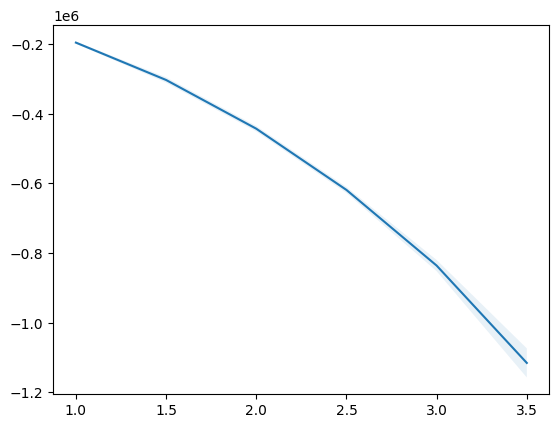

In [112]:
x = [1,1.5,2,2.5,3,3.5,4,4.5,5]

std = results.groupby(['mu']).std()['likelihood']
prec = results.groupby(['mu']).mean()['alpha precision']
kl_div = results.groupby(['mu']).mean()['kl divergence']
likelihood = results.groupby(['mu']).mean()['likelihood']

#plt.plot(x, prec, label = 'alpha precision')
#plt.plot(x, kl_div, label = 'inverse kl div')
plt.plot(x, likelihood, label = 'likelihood')

plt.fill_between(x, likelihood - std, likelihood + std, alpha=0.1)

#fig, ax1 = plt.subplots()

# Plot the first series with the primary y-axis
#ax1.plot(x, prec, label = 'alpha precision')
#ax1.plot(x, kl_div, label = 'inverse kl div')

# Create a second y-axis and plot the second series
#ax2 = ax1.twinx()
#ax2.plot(x, likelihood, label = 'likelihood', c = 'darkgreen')

#ax1.legend()
#ax2.legend()
plt.savefig('plots/covariate_shift_illustrative.png')


#plt.ylim([-0.05,1])

#plt.savefig('plots/covariate_shift_mu.png')

In [140]:
#to show metrics dont penalise complete swapping of treatment populations

alpha = AlphaPrecision()
kl = InverseKLDivergence()
m = 3

X_0 = pd.DataFrame(np.random.normal(loc = m, size=(1000,20)))
X_1 = pd.DataFrame(np.random.normal(loc = -m, size=(1000,20)))
X_0['w'] = 0
X_1['w'] = 1
d = pd.concat([X_0, X_1], axis=0)
d['y'] = np.random.normal(loc = 0, size=(2000,1))


X_0 = pd.DataFrame(np.random.normal(loc = m, size=(1000,20)))
X_1 = pd.DataFrame(np.random.normal(loc = -m, size=(1000,20)))
X_0['w'] = 1
X_1['w'] = 0
d_adv = pd.concat([X_0, X_1], axis=0)
d_adv['y'] = np.random.normal(loc = 0, size=(2000,1))

alpha.evaluate(GenericDataLoader(d), GenericDataLoader(d_adv))

{'delta_precision_alpha_OC': 0.6652666666666667,
 'delta_coverage_beta_OC': 0.18786666666666652,
 'authenticity_OC': 0.77,
 'delta_precision_alpha_naive': 0.9853850574712644,
 'delta_coverage_beta_naive': 0.0,
 'authenticity_naive': 1.0}

In [141]:
kl.evaluate(GenericDataLoader(d), GenericDataLoader(d_adv))

{'marginal': 0.9952790788607224}

In [352]:
covariate_fidelity(d, {'d_adv':d_adv, 'real':d}, 'w', 'y')

,dataset,f0,f1,covariate fidelity
0,d_adv,0.000000,0.000000,0.000000
1,real,0.999336,0.999336,0.999336


##  Subgroup dropping

In [24]:
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

In [25]:
#to show current models consistently drop subgroups
def subgroup_example(n_small, n_iter, save=False):
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()
    results = pd.DataFrame(columns = ['subgroups', 'beta recall', 'kl', 'proportion modelled'])

    for n in n_small:

        vectors_list = [np.repeat(-5*i, 10) for i in range(n+1)]

        def closest_vector(row):
            row = row[[str(i) for i in range(10)]]
            distances = [euclidean_distance(row, vector) for vector in vectors_list]
            closest_index = np.argmin(distances)
            return closest_index
        
        for _ in range(n_iter):
            X_main = pd.DataFrame(np.random.normal(loc = 0, size=(1000,10)))
            X_main['w']=0
            X_main.loc[0:len(X_main)/2-1, 'w']=1

            X_smalls = pd.DataFrame()
            for i in range(n):
                X = pd.DataFrame(np.random.normal(loc = -5*(i+1), size=(10,10)))
                X['w']=0
                X.loc[0:len(X)/2-1, 'w']=1

                X_smalls = pd.concat([X_smalls, X], axis=0)

            d = pd.concat([X_main, X_smalls], axis=0)
            d['y'] = np.random.normal(loc = 0, size=(1000+n*10,1))
            g = Plugins().get('ctgan')
            g.fit(d)
            synth = g.generate(count = 1000 + n*10)
            

            recall = alpha.evaluate(GenericDataLoader(d), synth)['delta_coverage_beta_OC']
            kl_div = kl.evaluate(GenericDataLoader(d), synth)['marginal']

            synth.dataframe()['subgroup'] = synth.dataframe().apply(closest_vector, axis=1)
            subgroups = len(synth.dataframe().groupby('subgroup').count())
            proportion_modelled = subgroups / (n+1)

            results.loc[(len(results))] = [n, recall, kl_div, proportion_modelled]

    if save:
        results.to_csv('subgroup_example_ctgan.csv', index=False)  
    return results

In [86]:
results = subgroup_example([1,2,3,4,5,6,7,8,9,10], 5, save=True)

[2024-04-28T16:51:24.693614+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:51:24.694311+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:51:24.694723+0000][3754226][CRITICAL] module plugin_goggle load failed
 40%|███▉      | 799/2000 [01:21<02:02,  9.77it/s]
[2024-04-28T16:52:50.323335+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:52:50.324083+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:52:50.324539+0000][3754226][CRITICAL] module plugin_goggle load failed
 37%|███▋      | 749/2000 [01:16<02:08,  9.75it/s]
[2024-04-28T16:54:11.007238+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:54:11.

In [98]:
results = pd.read_csv('subgroup_example_ctgan.csv')

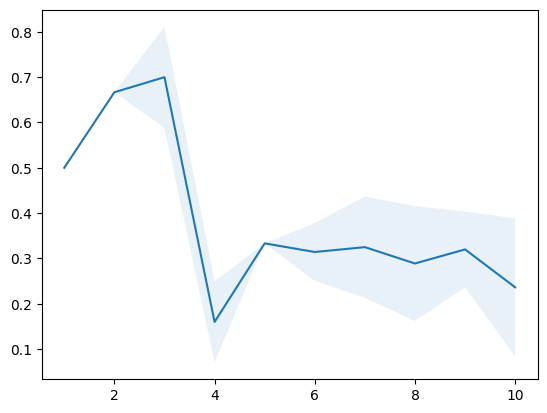

In [110]:
x = [1,2,3,4,5,6,7,8,9,10]
prop = 1- results.groupby('subgroups').mean()['proportion modelled']
std = results.groupby('subgroups').std()['proportion modelled']

plt.plot(prop)
plt.fill_between(x, prop - std, prop + std, alpha=0.1)
plt.savefig('plots/subgroup_illustrative.png')

## Propensity Failure

In [455]:
#to show metric failure for subgroup dropping
n = 10
n_cov = 50
alpha = AlphaPrecision()
kl = InverseKLDivergence()
d = pd.DataFrame(np.random.normal(loc = 0, size=(1000,n_cov)))
d['w']=0
d.loc[0:len(d)/2-1, 'w']=1

d_adv = d.copy()
d_adv['w'] = 1
d_adv.loc[len(d_adv)-1, 'w']=0

d['y']=0
d_adv['y']=0

recall = alpha.evaluate(GenericDataLoader(d), GenericDataLoader(d_adv))['delta_coverage_beta_OC']
kl_div = kl.evaluate(GenericDataLoader(d), GenericDataLoader(d_adv))['marginal']

In [456]:
print(f'recall: {recall}, kl div: {kl_div}')

recall: 0.8202666666666667, kl div: 0.9858821235211305


In [457]:
evaluate_d(d, d_adv, 'w', 'y')

0.5090279352328668

In [460]:
def propensity_degeneration(n_cov, n_iter):
    results = pd.DataFrame(columns=['n_cov', 'avg propensity real', 'avg propensity synth', 'kl', 'beta recall'])
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()

    for n in n_cov:
        for _ in range(n_iter):
            d = pd.DataFrame(np.random.normal(loc = 0, size=(1000,n)))
            d['w']=0
            d.loc[0:len(d)/2-1, 'w']=1
            d['y'] = np.random.normal(loc = 0, size=(1000,1))
            d = d.sample(frac=1)

            g = Plugins().get('ddpm')
            g.fit(d)
            s = g.generate(1000).dataframe()

            d_train = d[:900]
            d_test = d[900:]
            s_train = s[:900]

            pi_real = train_propensity_function(d_train, 'w', 'y')
            probabilities_real = pi_real.predict_proba(np.array(d_test.drop(['w', 'y'], axis=1)))
            propensities_real = probabilities_real[:, 1]
            avg_prop_real = np.mean(propensities_real)

            pi_synth = train_propensity_function(s_train, 'w', 'y')
            probabilities_synth = pi_synth.predict_proba(np.array(d_test.drop(['w', 'y'], axis=1)))
            propensities_synth = probabilities_synth[:, 1]
            avg_prop_synth = np.mean(propensities_synth)


            beta = alpha.evaluate(GenericDataLoader(d), GenericDataLoader(s))['delta_coverage_beta_OC']
            kl_div = kl.evaluate(GenericDataLoader(d), GenericDataLoader(s))['marginal']
            results.loc[(len(results))] = [n, avg_prop_real, avg_prop_synth, kl_div, beta]

    return results

In [461]:
results_ddpm = propensity_degeneration([1,10,20,30,40,50], 3)

[2024-05-01T04:59:22.705805+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-01T04:59:22.706680+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-01T04:59:22.707046+0000][179846][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.92it/s, loss=1.19]
[2024-05-01T04:59:39.341881+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-01T04:59:39.342571+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-01T04:59:39.342952+0000][179846][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.65it/s, loss=1.2]
[2024-05-01T04:59:56.111498+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 

In [464]:
mses_real = [mean_squared_error(results_ddpm[results_ddpm['n_cov']==i]['avg propensity real'], np.repeat(0.5, 3), squared = False) for i in [1,10,20,30,40,50]]
mses_synth = [mean_squared_error(results_ddpm[results_ddpm['n_cov']==i]['avg propensity synth'], np.repeat(0.5, 3), squared = False) for i in [1,10,20,30,40,50]]

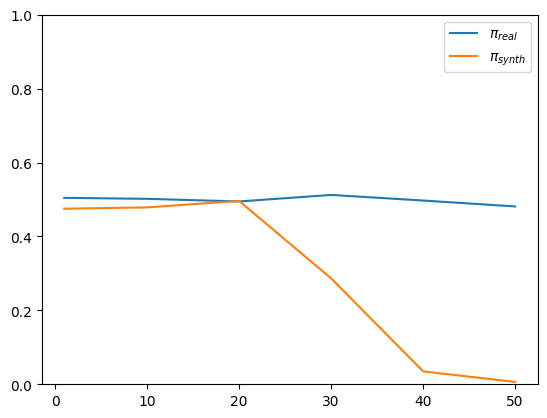

In [463]:
X = [1,10,20,30,40,50]

real_y = results_ddpm.groupby('n_cov').mean()['avg propensity real']
synth_y = results_ddpm.groupby('n_cov').mean()['avg propensity synth']
plt.plot(real_y, label = '$\pi_{real}$')
plt.plot(synth_y, label = '$\pi_{synth}$')
plt.legend()

plt.ylim([0,1])
plt.savefig('plots/propensity_failure.png')

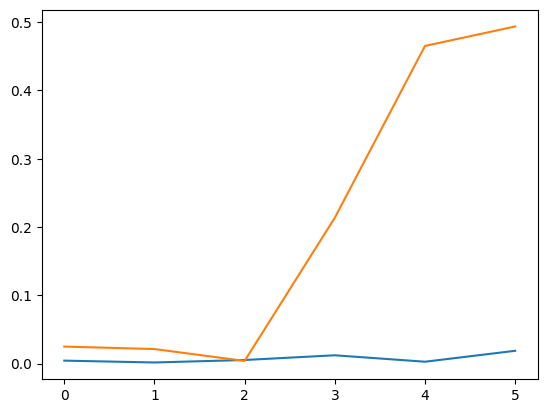

In [465]:
plt.plot(mses_real)
plt.plot(mses_synth)

In [467]:
results_ddpm.to_csv('propensity_failure_ddpm.csv', index=False)

## New generation ideas

### Training a generator for each treatment group

In [406]:
def train_models_separate(gen_list, datasets, n_runs, treatment_cols):
    j=0

    for g in gen_list:
        for d in datasets:
            treatment_col = treatment_cols[j]

            dataset = datasets[d]
            dataset_0 = dataset[dataset[treatment_col] == 0].drop(treatment_col, axis=1)
            dataset_1 = dataset[dataset[treatment_col] == 1].drop(treatment_col, axis=1)

            for i in range(n_runs):

                print(f'Training model {g} iteration {i} on dataset {d} treatment 0')
                model = Plugins().get(g)
                model.fit(dataset_0)
                fp = 'separate_models/' + g + '_' + d + '0_' + str(i) + '.pkl'
                save_to_file(fp, model)

                print(f'Training model {g} iteration {i} on dataset {d} treatment 1')
                model = Plugins().get(g)
                model.fit(dataset_1)
                fp = 'separate_models/' + g + '_' + d + '1_' + str(i) + '.pkl'
                save_to_file(fp, model)
        j += 1

In [419]:
def generate_data_separate(model0, model1, pi, n, treatment_col):
    n_1 = round(n*pi)
    n_0 = n - n_1

    g_0 = load_from_file('separate_models/' + model0)
    g_1 = load_from_file('separate_models/' + model1)
    df_0 = g_0.generate(count = n_0).dataframe()
    df_0[treatment_col] = 0
    df_1 = g_1.generate(count = n_1).dataframe()
    df_1[treatment_col] = 1

    df = pd.concat([df_0, df_1])

    model0 = model0.split('.')[0]
    name_list = model0.split('_')
    name = name_list[0] + '_' + name_list[1][:-1] + '_' + name_list[2]
    df.to_csv('syn_data_separate/' + name + '_separate.csv', index=False)

In [324]:
def gen_sep(real, gen, treatment_col):
    dataset_0 = real[real[treatment_col] == 0].drop(treatment_col, axis=1)
    dataset_1 = real[real[treatment_col] == 1].drop(treatment_col, axis=1)
    n = len(real)
    pi = sum(real[treatment_col]) / n
    n_1 = round(n*pi)
    n_0 = n - n_1
    g_0 = Plugins().get(gen)
    g_0.fit(dataset_0)
    g_1 = Plugins().get(gen)
    g_1.fit(dataset_1)
    df_0 = g_0.generate(count = n_0).dataframe()
    df_0[treatment_col] = 0
    df_1 = g_1.generate(count = n_1).dataframe()
    df_1[treatment_col] = 1
    df = pd.concat([df_0, df_1])

    return df

In [351]:
m = 1

X_0 = pd.DataFrame(np.random.normal(loc = m, size=(2000,20)))
X_1 = pd.DataFrame(np.random.normal(loc = -m, size=(2000,20)))
X_0['w'] = 0
X_1['w'] = 1
d = pd.concat([X_0, X_1], axis=0)
d['y'] = np.random.normal(loc = 0, size=(4000,1))

In [352]:
synth_sep = gen_sep(d, 'ctgan', 'w')

[2024-04-30T07:45:40.868909+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:45:40.869464+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:45:40.869947+0000][4191568][CRITICAL] module plugin_goggle load failed
 42%|████▏     | 849/2000 [02:59<04:03,  4.73it/s]
[2024-04-30T07:48:47.132985+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:48:47.133526+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:48:47.133968+0000][4191568][CRITICAL] module plugin_goggle load failed
 27%|██▋       | 549/2000 [01:54<05:02,  4.79it/s]


In [353]:
synth = generate_standard(d, 'ctgan')

[2024-04-30T07:50:48.657028+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:50:48.658350+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:50:48.658777+0000][4191568][CRITICAL] module plugin_goggle load failed
 27%|██▋       | 549/2000 [04:42<12:26,  1.94it/s]


In [356]:
evaluate_d(d, synth_sep, 'w', 'y')

0.002374114615312479

In [357]:
evaluate_d(d, synth, 'w', 'y')

0.014232456084814337

In [427]:
gen_list = ['ddpm']
datasets = {}
datasets['acic'] = acic

In [428]:
train_models_separate(gen_list, datasets, 1, ['z'])

[2024-04-29T04:10:11.992729+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:10:11.993217+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:10:11.993525+0000][3754226][CRITICAL] module plugin_goggle load failed


Training model ddpm iteration 0 on dataset acic treatment 0


Epoch: 100%|██████████| 1000/1000 [01:32<00:00, 10.76it/s, loss=0.876]
[2024-04-29T04:11:45.183756+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:11:45.184238+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:11:45.184579+0000][3754226][CRITICAL] module plugin_goggle load failed


Training model ddpm iteration 0 on dataset acic treatment 1


Epoch: 100%|██████████| 1000/1000 [00:22<00:00, 44.65it/s, loss=1.26]


In [426]:
sum(acic['z'])/len(acic)

0.17867555185339443

In [429]:
generate_data_separate('ddpm_acic0_0.pkl', 'ddpm_acic0_0.pkl', 0.179, 747, 'treatment')

In [430]:
separate = pd.read_csv('syn_data_separate/ddpm_acic_0_separate.csv')

In [434]:
separate = separate.rename(columns = {'treatment':'z'})

### Generation in a sequential manner, mimicing the true DGP

Given a real dataset $D = [X, W, Y]$, will train a generative model only on the covariates $X$. Then will predict the treatment assignment $W$ based on the propensity score $\pi(x)$ for each instance, where $\pi(.)$ is learnt from the real dataset. Then, will generate the outcomes $Y$ based on a conditional generative model that has been trained on $D$.

In [241]:
def generate_sequentially(real, gen, treatment_col, outcome_col, encode=False):
    random.seed()

    #generate covariates
    g = Plugins().get(gen, random_state = random.randint(0, 1000000))
    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    g.fit(real_cov)
    synth_cov = g.generate(count = len(real)).dataframe()

    if encode:
        real_encoded, syn_encoded = encode_acic(real, synth_cov)
    else:
        real_encoded, syn_encoded = real, synth_cov

    #generate propensities
    X = np.array(real_encoded.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real_encoded[treatment_col])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    classifier.fit(X_train, y_train)
    probabilities = classifier.predict_proba(np.array(syn_encoded))
    prob_class_1 = probabilities[:, 1]
    binary_outcomes = np.random.binomial(n=1, p=prob_class_1)
    synth_cov_with_prop = np.column_stack((binary_outcomes, np.array(synth_cov)))
    synth_cov_with_prop = pd.DataFrame(synth_cov_with_prop, columns=real.drop(outcome_col, axis=1).columns)

    #generate outcome
    g_cond = Plugins().get(gen, random_state = random.randint(0, 1000000))
    g_cond.fit(real, cond = real.drop(outcome_col, axis=1))
    synth_cov_with_prop_and_y = g_cond.generate(count = len(real), cond = synth_cov_with_prop)
    
    return synth_cov_with_prop_and_y.dataframe()

In [242]:
def generate_standard(real, gen):
    random.seed()
    g = Plugins().get(gen, random_state = random.randint(0, 1000000))
    g.fit(real)
    synth = g.generate(count = len(real)).dataframe()
    return synth

In [243]:
def sequential_exp(real, gens, treatment_col, outcome_col, n_iter, encode = False, save=False, fp=''):
    results = pd.DataFrame(columns = ['type', 'gen', 'alpha precision', 'beta recall', 'kl', 'f', 'd', 'u_pehe', 'u_policy', 'u_int'])

    for gen in gens:
        for _ in range(n_iter):
            alpha = AlphaPrecision(random_state = random.randint(0, 1000000))
            kl = InverseKLDivergence(random_state = random.randint(0, 1000000))
            #train and evaluate normal synth gen
            synth = generate_standard(real, gen)
        
            if encode:
                real_encoded, synth_encoded = encode_acic(real, synth)
            else:
                real_encoded = real
                synth_encoded = synth

            n_units = len(real_encoded.drop([treatment_col, outcome_col], axis=1).columns)
            standard_f = evaluate_f(real_encoded, synth_encoded, treatment_col, outcome_col)
            standard_d = evaluate_d(real_encoded, synth_encoded, treatment_col, outcome_col)
            standard_u_pehe = evaluate_u_pehe(real_encoded, synth_encoded, treatment_col, outcome_col, n_units)
            standard_u_policy = evaluate_u_policy(real_encoded, synth_encoded, treatment_col, outcome_col, n_units)
            standard_u_int = evaluate_u_int(real_encoded, synth_encoded, treatment_col, outcome_col, n_units)[0]
            standard_alpha = alpha.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_encoded))['delta_precision_alpha_OC']
            standard_beta = alpha.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_encoded))['delta_coverage_beta_OC']
            standard_kl = kl.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_encoded))['marginal']
            results.loc[(len(results))] = ['standard', gen, standard_alpha, standard_beta, standard_kl, standard_f, standard_d, standard_u_pehe, standard_u_policy, standard_u_int]

            #train and evaluate sequential synth gen

            synth_sequential = generate_sequentially(real, gen, treatment_col, outcome_col, encode=encode)

            if encode:
                real_encoded, synth_sequential_encoded = encode_acic(real, synth_sequential)
            else:
                real_encoded = real
                synth_sequential_encoded = synth_sequential
            
            sequential_f = evaluate_f(real_encoded, synth_sequential_encoded, treatment_col, outcome_col)
            sequential_d = evaluate_d(real_encoded, synth_sequential_encoded, treatment_col, outcome_col)
            sequential_u_pehe = evaluate_u_pehe(real_encoded, synth_sequential_encoded, treatment_col, outcome_col, n_units)
            sequential_u_policy = evaluate_u_policy(real_encoded, synth_sequential_encoded, treatment_col, outcome_col, n_units)
            sequential_u_int = evaluate_u_int(real_encoded, synth_sequential_encoded, treatment_col, outcome_col, n_units)[0]
            sequential_alpha = alpha.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_sequential_encoded))['delta_precision_alpha_OC']
            sequential_beta = alpha.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_sequential_encoded))['delta_coverage_beta_OC']
            sequential_kl = kl.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_sequential_encoded))['marginal']
            results.loc[(len(results))] = ['sequential', gen, sequential_alpha, sequential_beta, sequential_kl, sequential_f, sequential_d, sequential_u_pehe, sequential_u_policy, sequential_u_int]

    if save:
        results.to_csv(fp, index=False)

    return results

In [246]:
results_acic = sequential_exp(acic, ['ctgan', 'tvae'], 'z', 'y', 10, encode=True, save=True, fp='sequential_acic.csv')

[2024-05-02T12:18:47.998260+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:18:47.999657+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:18:48.000479+0000][845410][CRITICAL] module plugin_goggle load failed
  3%|▎         | 53/2000 [01:02<43:56,  1.35s/it]  Exception ignored in: <function _xla_gc_callback at 0x7f614994e200>
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
  3%|▎         | 65/2000 [01:16<37:46,  1.17s/it]


KeyboardInterrupt: 

In [ ]:
results_acic

In [ ]:
results_ihdp = sequential_exp(ihdp, ['ctgan', 'tvae'], 'z', 'y', 10, encode=False, save=True, fp='sequential_ihdp.csv')

In [ ]:
results_ihdp

In [244]:
test = sequential_exp(ihdp, ['ctgan'], 'treatment', 'y_factual', 1,encode=False)

[2024-05-02T12:13:13.824491+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:13:13.825775+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:13:13.826195+0000][845410][CRITICAL] module plugin_goggle load failed
 50%|████▉     | 999/2000 [01:41<01:41,  9.82it/s]
[2024-05-02T12:15:30.449183+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:15:30.450528+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:15:30.450963+0000][845410][CRITICAL] module plugin_goggle load failed
 32%|███▏      | 649/2000 [01:16<02:38,  8.50it/s]
[2024-05-02T12:16:47.722537+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:16:47.723160+

In [31]:
results = pd.read_csv('sequential_results.csv')

In [34]:
results.groupby(['gen', 'type']).std()

alpha precision  beta recall        kl         f         d  \
gen   type                                                                     
ctgan sequential         0.033037     0.021172  0.008357  0.034892  0.016167   
      standard           0.036844     0.032456  0.014393  0.043812  0.023874   
tvae  sequential         0.000000     0.000000  0.000000  0.000000  0.000000   
      standard           0.000000     0.000000  0.000000  0.000000  0.000000   

                    u_pehe  u_policy     u_int  
gen   type                                      
ctgan sequential  0.413258  0.063591  0.238126  
      standard    0.333809  0.061596  0.186170  
tvae  sequential  0.000000  0.000000  0.000000  
      standard    0.000000  0.000000  0.000000

In [36]:
results.groupby(['gen', 'type']).mean()

alpha precision  beta recall        kl         f         d  \
gen   type                                                                     
ctgan sequential         0.720286     0.414663  0.913332  0.268681  0.089418   
      standard           0.670799     0.414743  0.952885  0.252751  0.140448   
tvae  sequential         0.851406     0.404641  0.820582  0.298433  0.178706   
      standard           0.795984     0.427577  0.894903  0.192371  0.111379   

                    u_pehe  u_policy     u_int  
gen   type                                      
ctgan sequential  2.637129  0.838926  0.153424  
      standard    2.834454  0.783221  0.117513  
tvae  sequential  2.311922  0.885906  0.270680  
      standard    3.378427  0.704698 -0.058206

In [191]:
acic_encoded, _  = encode_acic(acic, acic.drop(['z'], axis=1))

In [201]:
acic_sample = acic.sample(frac=0.1).reset_index(drop=True)

In [202]:
test, _ = encode_acic(acic_sample, acic_sample)

In [208]:
s = generate_sequentially(acic_sample, 'ctgan', 'z', 'y', encode=True)

[2024-05-02T11:40:30.125648+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T11:40:30.127130+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T11:40:30.128055+0000][845410][CRITICAL] module plugin_goggle load failed
 30%|██▉       | 599/2000 [01:17<03:01,  7.70it/s]
[2024-05-02T11:41:51.249843+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T11:41:51.250338+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T11:41:51.251707+0000][845410][CRITICAL] module plugin_goggle load failed
 50%|████▉     | 999/2000 [01:50<01:50,  9.06it/s]


In [209]:
s

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,z,y
0,21,C,10.064859,4.303485,65,121,0,1,1,0,...,0,0,0,0,0,0,48,41,0,13.412184
1,26,C,7.812866,0.471930,62,148,0,0,0,0,...,0,0,0,0,0,0,49,37,0,-1.417854
2,20,B,20.518825,12.634060,64,104,0,0,0,0,...,0,0,1,0,0,0,46,38,1,0.215368
3,20,C,0.134449,0.000000,61,110,2,0,0,0,...,0,2,0,0,0,0,46,39,0,1.042513
4,24,C,18.978271,13.213449,61,115,0,0,0,0,...,0,0,0,0,0,0,47,40,1,0.482397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,33,C,18.803738,4.260575,61,145,3,0,0,0,...,0,0,0,0,0,0,43,40,1,1.396239
476,26,C,7.365983,0.620233,63,123,0,0,0,0,...,0,0,0,0,0,0,47,39,0,2.289888
477,25,C,0.465721,4.778617,60,120,0,0,0,0,...,0,0,0,0,0,0,47,37,0,0.858008
478,22,C,20.136637,6.374458,62,146,0,0,1,0,...,0,0,0,0,0,0,48,37,0,1.884321


In [213]:
acic_sample_encoded, s_encoded = encode_acic(acic_sample, s)

In [214]:
evaluate_f(acic_sample_encoded, s_encoded, 'z', 'y')

0.46754475262493356

In [228]:
evaluate_d(acic_sample_encoded, s_encoded, 'z', 'y')

0.6072273120726612

In [222]:
evaluate_u_policy(acic_sample_encoded, s_encoded, 'z', 'y', 78)

0.3854166666666667

In [223]:
s_s = generate_standard(acic_sample, 'ctgan')

[2024-05-02T11:49:13.974227+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T11:49:13.975254+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T11:49:13.975612+0000][845410][CRITICAL] module plugin_goggle load failed
 37%|███▋      | 749/2000 [01:40<02:48,  7.42it/s]


In [225]:
acic_sample_encoded, s_s_encoded = encode_acic(acic_sample, s_s)

In [226]:
evaluate_f(acic_sample_encoded, s_s_encoded, 'z', 'y')

0.4749071067821068

In [227]:
evaluate_d(acic_sample_encoded, s_s_encoded, 'z', 'y')

0.7247468439321014

In [229]:
evaluate_u_policy(acic_sample_encoded, s_s_encoded, 'z', 'y', 78)

0.5625

## Showing our metrics work

### F

In [194]:
def generate_covariate_shift_datasets(n, mu, correct):
    X_0 = pd.DataFrame(np.random.normal(loc = mu, size=(n,20)))
    X_1 = pd.DataFrame(np.random.normal(loc = -mu, size=(n,20)))
    X_0['w'] = 0
    X_1['w'] = 1
    d = pd.concat([X_0, X_1], axis=0).reset_index(drop=True)
    d['y'] = np.random.normal(loc = 0, size=(2*n,1))

    n_correct = round(correct*n)
    X_0_adv = pd.DataFrame(np.random.normal(loc = mu, size=(n,20)))
    X_0_adv['w'] = 1
    X_0_adv.loc[:n_correct, 'w']=0

    X_1_adv = pd.DataFrame(np.random.normal(loc = -mu, size=(n,20)))
    X_1_adv['w'] = 0
    X_1_adv.loc[:n_correct, 'w']=1

    d_adv = pd.concat([X_0_adv, X_1_adv], axis=0).reset_index(drop=True)
    d_adv['y'] = np.random.normal(loc = 0, size=(2*n,1))

    return d, d_adv

In [229]:
def new_metrics_covariate_shift_exp(n, mu, corrects, n_iter):
    results = pd.DataFrame(columns=['correct %', 'f', 'd', 'alpha', 'kl'])
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()

    for c in corrects:
        for _ in range(n_iter):
            d_real, d_adv = generate_covariate_shift_datasets(n, mu, c)
            f = evaluate_f(d_real,d_adv,'w','y')
            d = evaluate_d(d_real,d_adv,'w','y')
            prec = alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['delta_precision_alpha_OC']
            inv_kl = kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['marginal']
            results.loc[len(results)] = [c, f, d, prec, inv_kl]
            print('done')
    return results


In [230]:
results = new_metrics_covariate_shift_exp(1000, 4, [0,0.2,0.4,0.6,0.8,1], n_iter = 3)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [234]:
results.groupby('correct %').mean()

,f,d,alpha,kl
correct %,,,,
0.0,0.000656,9.989771e-01,0.749389,0.995414
0.2,0.197233,7.987756e-01,0.885088,0.994441
0.4,0.403556,6.004688e-01,0.672864,0.993013
0.6,0.600189,4.030066e-01,0.904268,0.995010
0.8,0.775722,2.026310e-01,0.895829,0.994491
1.0,0.978070,3.676999e-07,0.984003,0.995929


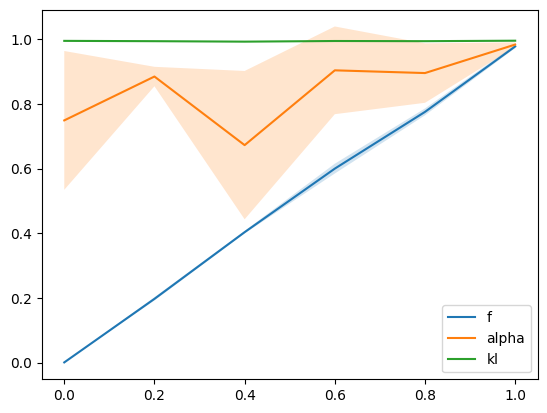

In [239]:
x = [0,0.2,0.4,0.6,0.8,1]
f = results.groupby('correct %').mean()['f']
alpha = results.groupby('correct %').mean()['alpha']
kl = results.groupby('correct %').mean()['kl']
f_std = results.groupby('correct %').std()['f']
alpha_std = results.groupby('correct %').std()['alpha']
kl_std = results.groupby('correct %').std()['kl']

plt.plot(x, f, label = 'f')
plt.plot(x, alpha, label = 'alpha')
plt.plot(x, kl, label = 'kl')

plt.fill_between(x, f - f_std, f + f_std, alpha=0.2)
plt.fill_between(x, alpha - alpha_std, alpha + alpha_std, alpha=0.2)
plt.fill_between(x, kl - kl_std, kl + kl_std, alpha=0.2)
plt.legend()
plt.show()

### D

In [285]:
def generate_propensities_datasets(n, correct):
    d = pd.DataFrame(np.random.normal(loc = 0, size=(n,20)))
    d['w'] = 0
    d.loc[:round(n/2),'w'] = 1
    d['y'] = np.random.normal(loc = 0, size=(n,1))
    d = d.sample(frac=1)

    n_correct = round(correct*n)
    d_adv = pd.DataFrame(np.random.normal(loc = 0, size=(n,20)))
    d_adv['w'] = 0
    d_adv.loc[:n_correct,'w'] = 1
    d_adv['y'] = np.random.normal(loc = 0, size=(n,1))
    d_adv = d_adv.sample(frac=1)

    return d, d_adv

In [257]:
def new_metrics_propensity_exp(n, corrects, n_iter):
    results = pd.DataFrame(columns=['treated %', 'f', 'd', 'beta', 'kl'])
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()

    for c in corrects:
        for _ in range(n_iter):
            d_real, d_adv = generate_propensities_datasets(n, c)
            f = evaluate_f(d_real,d_adv,'w','y')
            d = evaluate_d(d_real,d_adv,'w','y')
            prec = alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['delta_coverage_beta_OC']
            inv_kl = kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['marginal']
            results.loc[len(results)] = [c, f, d, prec, inv_kl]
            print('done')
    return results


In [320]:
results_prop = new_metrics_propensity_exp(2000, [0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8,0.9], 3)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [321]:
results_prop

,treated %,f,d,beta,kl
0,0.1,0.308524,0.270108,0.364600,0.980896
1,0.1,0.236733,0.251113,0.372433,0.978339
2,0.1,0.333037,0.245276,0.390567,0.979901
3,0.2,0.322410,0.431848,0.388767,0.982943
4,0.2,0.427440,0.425160,0.396467,0.985963
5,0.2,0.399186,0.430076,0.424267,0.982825
6,0.3,0.368334,0.596815,0.418233,0.990906
7,0.3,0.397887,0.601237,0.429600,0.987149
8,0.3,0.413651,0.626726,0.388800,0.989306
9,0.4,0.548843,0.782811,0.428567,0.989553


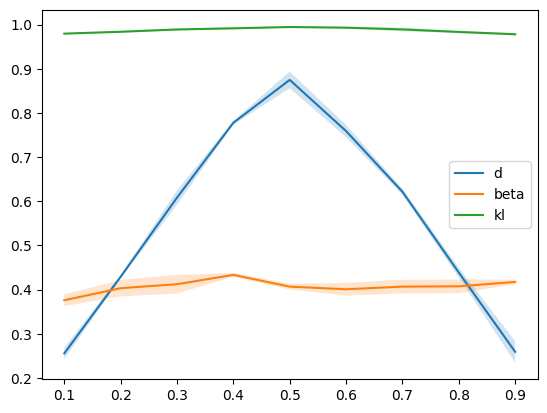

In [323]:
x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
d = results_prop.groupby('treated %').mean()['d']
beta = results_prop.groupby('treated %').mean()['beta']
kl = results_prop.groupby('treated %').mean()['kl']
d_std = results_prop.groupby('treated %').std()['d']
beta_std = results_prop.groupby('treated %').std()['beta']
kl_std = results_prop.groupby('treated %').std()['kl']

plt.plot(x, d, label = 'd')
plt.plot(x, beta, label = 'beta')
plt.plot(x, kl, label = 'kl')

plt.fill_between(x, d - d_std, d + d_std, alpha=0.2)
plt.fill_between(x, beta - beta_std, beta + beta_std, alpha=0.2)
plt.fill_between(x, kl - kl_std, kl + kl_std, alpha=0.2)
plt.legend()
plt.show()

### U

In [128]:
def create_simulated_datasets(n, d, n_o, n_t, n_known, error_sd=0):
    X,y,w,p,t = simulate_treatment_setup(n, d=d, n_o=n_o, n_t=n_t, error_sd=error_sd)
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y, columns = ['y'])
    w_df = pd.DataFrame(w, columns = ['w'])

    d_real = pd.concat([X_df,w_df,y_df], axis=1)
    d_synth = pd.concat([X_df,w_df], axis=1)

    mu0_coefs = np.ones(n_o)
    mu0 = np.dot(X[:, : n_o] ** 2, mu0_coefs)

    mu1_coefs = np.ones(n_known)
    X_sel = X[:, n_o : n_o + n_known]
    mu1 = mu0 + np.dot(X_sel**2, mu1_coefs)

    new_column_values = []
    for index, value in d_synth['w'].iteritems():
        if value == 0:
            new_column_values.append(mu0[index])
        else:
            new_column_values.append(mu1[index])

    d_synth['y'] = new_column_values

    return d_real, d_synth

In [161]:
def run_utility_exp(n, d, n_o, n_t, n_knowns, n_iter, error_sd=0):
    results = pd.DataFrame(columns=['n_known', 'u_pehe', 'u_policy', 'u_int'])
    for n_known in n_knowns:
        for _ in range(n_iter):
            d_real, d_synth = create_simulated_datasets(n, d,n_o, n_t, n_known)
            u_pehe = evaluate_u_pehe(d_real, d_synth, 'w', 'y', n_units=d)
            u_policy = evaluate_u_policy(d_real, d_synth, 'w', 'y', n_units=d)
            u_int = evaluate_u_int(d_real, d_synth, 'w', 'y', n_units=d)[0]

            results.loc[len(results)] = [n_known, u_pehe, u_policy, u_int]
            print(f'done {n_known} {_}')

    return results

In [142]:
results = run_utility_exp(1000, 10, 5, 5, [0,1,2,3,4,5], n_iter = 3)

done 0 0
done 0 1
done 0 2
done 1 0
done 1 1
done 1 2
done 2 0
done 2 1
done 2 2
done 3 0
done 3 1
done 3 2
done 4 0
done 4 1
done 4 2
done 5 0
done 5 1
done 5 2


In [148]:
results['u_int_1'] = [i[0] for i in results['u_int']]

In [152]:
results.groupby('n_known').mean()

,u_pehe,u_policy,u_int_1
n_known,,,
0,5.606552,0.406667,0.142616
1,4.806990,0.753333,0.497962
2,3.639405,0.895000,0.715766
3,2.632724,0.931667,0.687902
4,1.799999,0.980000,0.833313
5,1.268741,0.983333,0.907670


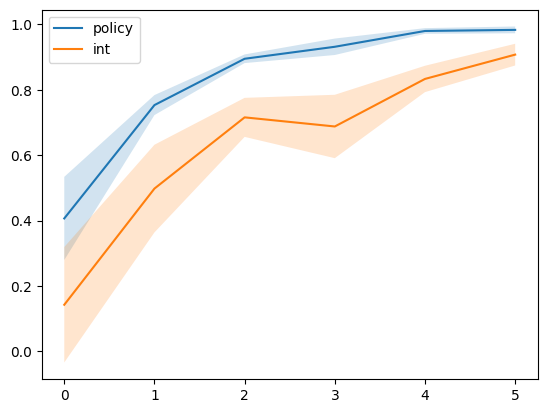

In [166]:
x = [0,1,2,3,4,5]
u_pehe = results.groupby('n_known').mean()['u_pehe']
u_policy = results.groupby('n_known').mean()['u_policy']
u_int = results.groupby('n_known').mean()['u_int_1']
u_pehe_std = results.groupby('n_known').std()['u_pehe']
u_policy_std = results.groupby('n_known').std()['u_policy']
u_int_std = results.groupby('n_known').std()['u_int_1']


plt.plot(x, u_policy, label = 'policy')
plt.plot(x, u_int, label = 'int')


plt.fill_between(x, u_policy - u_policy_std, u_policy + u_policy_std, alpha=0.2)
plt.fill_between(x, u_int - u_int_std, u_int + u_int_std, alpha=0.2)
plt.legend()
plt.show()

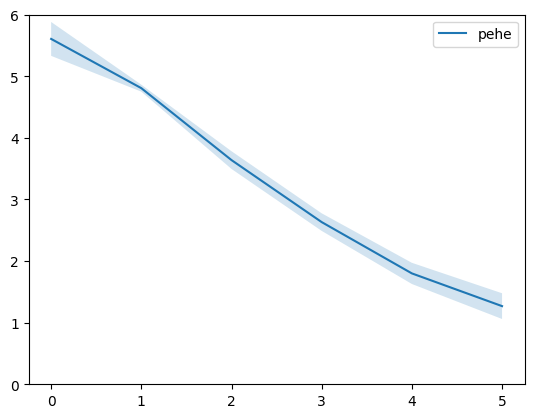

In [167]:
plt.plot(x, u_pehe, label = 'pehe')
plt.fill_between(x, u_pehe - u_pehe_std, u_pehe + u_pehe_std, alpha=0.2)
plt.legend()
plt.ylim([0,6])
plt.show()

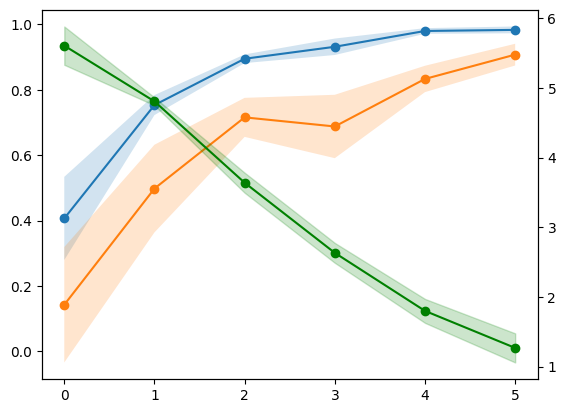

In [173]:
fig, ax1 = plt.subplots()
ax1.plot(x, u_policy, 'o-', label = 'policy')
ax1.plot(x, u_int, 'o-', label = 'int')
ax1.fill_between(x, u_policy - u_policy_std, u_policy + u_policy_std, alpha=0.2)
ax1.fill_between(x, u_int - u_int_std, u_int + u_int_std, alpha=0.2)

ax2 = ax1.twinx()
ax2.plot(x, u_pehe, 'o-', label = 'pehe', color='g')
ax2.fill_between(x, u_pehe - u_pehe_std, u_pehe + u_pehe_std, alpha=0.2, color='g')